<img src="http://www.itertop.com/assets/img/iterlogo/logo-itertop-appletouch.png" align="left" width="50" height="50"> 

# Employee Turnover Prediction

The task is to define whether it is possible to predict employee turnover from a given dataset and provide the most accurate prediction model.

## Introduction

So solve the task a number of statistical & machine learning methods to be applied and compared: logistic regression, random forests, decision trees, gradient boost (two different implementations), and deep learning.

## 1. Reading data

In [57]:
from IPython.core.interactiveshell import InteractiveShell
# enabling output for all commands in a cell with "all"
#InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr"

In [58]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [59]:
df = pd.read_csv("/data/turnover.csv",
                           index_col=None)
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


A real, but scrambled dataset is used for public use. Dataset credits: __[Edward Babushkin](https://edwvb.blogspot.com/2017/10/employee-turnover-how-to-predict-individual-risks-of-quitting.html?m=1)__<br>
**Target: ** "event" - termination event.<br>
**Features: ** "stag" - experience, "gender", "age", "industry", "profession", "traffic" - a pipelene candidate came to the company from, "coach" - presence of a coach on the probation, "head_gender", "greywage" - part of the salary paid indirectly, "way" -   how an employee gets to workplace (by feet, by bus etc); "extraversion", "independ", "selfcontrol", "anxiety", "novator" - Big5 test scales.
Comments: 'independ’ translates to a reversed scale of agreeableness, ‘selfcontrol’ is conscientiousness, ‘anxiety’ is neuroticism, and ‘novator’ stands for openness.

## 2. Cleansing & Exploring

In [60]:
# Get column names
column_names = df.columns
print(column_names)
# Get column data types
df.dtypes
# Also check if the column is unique
for i in column_names:
  print('{} is unique: {}'.format(i, df[i].is_unique))

Index([u'stag', u'event', u'gender', u'age', u'industry', u'profession',
       u'traffic', u'coach', u'head_gender', u'greywage', u'way',
       u'extraversion', u'independ', u'selfcontrol', u'anxiety', u'novator'],
      dtype='object')
stag is unique: False
event is unique: False
gender is unique: False
age is unique: False
industry is unique: False
profession is unique: False
traffic is unique: False
coach is unique: False
head_gender is unique: False
greywage is unique: False
way is unique: False
extraversion is unique: False
independ is unique: False
selfcontrol is unique: False
anxiety is unique: False
novator is unique: False


In [61]:
# do we have missing values
df.isnull().any()

stag            False
event           False
gender          False
age             False
industry        False
profession      False
traffic         False
coach           False
head_gender     False
greywage        False
way             False
extraversion    False
independ        False
selfcontrol     False
anxiety         False
novator         False
dtype: bool

No missing values, acceptable to explore

In [62]:
df.shape
df.dtypes

stag            float64
event             int64
gender           object
age             float64
industry         object
profession       object
traffic          object
coach            object
head_gender      object
greywage         object
way              object
extraversion    float64
independ        float64
selfcontrol     float64
anxiety         float64
novator         float64
dtype: object

In [63]:
groupedByEvent = df.groupby(['event'])
groupedByEvent['stag'].count()

event
0    558
1    571
Name: stag, dtype: int64

Total number of separated employees (event = 0) vs still working (event =1) 

In [64]:
#averages of all the values grouped by the target event
groupedByEvent.mean()

,stag,age,extraversion,independ,selfcontrol,anxiety,novator
event,,,,,,,
0,38.294819,31.411829,5.563441,5.388710,5.677419,5.774910,5.866487
1,34.998191,30.729952,5.620665,5.565324,5.518914,5.558844,5.892469


In [65]:
#overall statistical dataset description 
df.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,36.627526,0.505757,31.066965,5.592383,5.478034,5.597254,5.665633,5.879628
std,34.096597,0.500188,6.996147,1.851637,1.703312,1.980101,1.709176,1.904016
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.728953,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.344969,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.318275,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Employee turnover distribution by industry

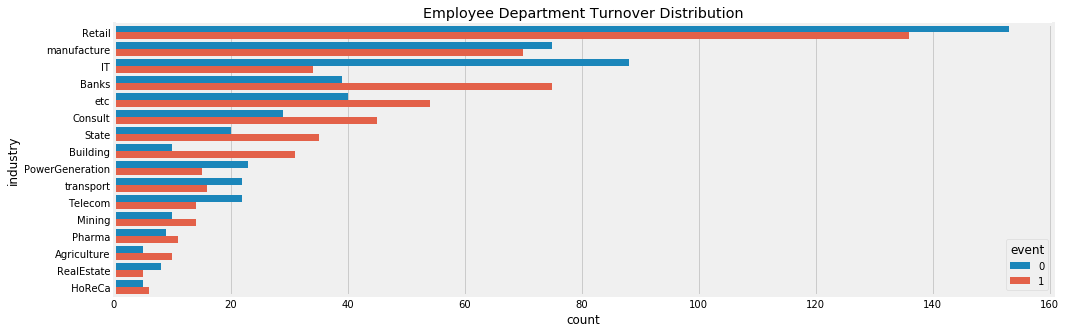

In [66]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y='industry', hue='event', data=df, order=df['industry'].value_counts().index).set_title('Employee Department Turnover Distribution');

Converting text categorical features into numbers to measure correlation and feed to the models later on

In [67]:
import numbers
df_normalized = df.copy()
for column in df:
    if not isinstance(df[column][0], numbers.Number):
        df_normalized[column] = pd.factorize(df[column])[0]
df_normalized.head()
#we'll use the same dataset name currently 
df = df_normalized

In [68]:
#Correlation Matrix or "heatmap"
corrMatrix = df.corr().round(decimals=2)
corrMatrix = (corrMatrix)
corrMatrix

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
stag,1.00,-0.05,-0.04,-0.20,-0.01,0.08,0.06,0.02,-0.01,-0.12,0.07,-0.09,0.00,0.08,0.01,-0.04
event,-0.05,1.00,0.02,-0.05,-0.06,0.07,-0.10,-0.04,0.04,0.05,-0.07,0.02,0.05,-0.04,-0.06,0.01
gender,-0.04,0.02,1.00,-0.06,-0.01,-0.41,-0.07,0.07,-0.21,0.02,-0.06,0.15,0.12,-0.08,-0.32,-0.01
age,-0.20,-0.05,-0.06,1.00,0.05,-0.03,0.03,-0.26,0.20,0.03,0.06,-0.15,0.06,0.04,0.06,0.04
industry,-0.01,-0.06,-0.01,0.05,1.00,0.12,0.01,-0.01,0.10,-0.06,-0.01,-0.07,0.02,0.02,-0.01,-0.02
profession,0.08,0.07,-0.41,-0.03,0.12,1.00,0.09,-0.00,0.21,-0.03,0.05,-0.06,-0.03,-0.00,0.11,-0.00
traffic,0.06,-0.10,-0.07,0.03,0.01,0.09,1.00,-0.05,0.03,-0.05,0.10,-0.03,0.03,-0.01,0.01,0.02
coach,0.02,-0.04,0.07,-0.26,-0.01,-0.00,-0.05,1.00,-0.10,-0.03,-0.07,0.06,0.04,-0.01,-0.05,-0.05
head_gender,-0.01,0.04,-0.21,0.20,0.10,0.21,0.03,-0.10,1.00,0.03,0.01,-0.01,-0.05,-0.04,0.04,0.04
greywage,-0.12,0.05,0.02,0.03,-0.06,-0.03,-0.05,-0.03,0.03,1.00,-0.07,0.01,-0.10,-0.02,0.07,-0.01


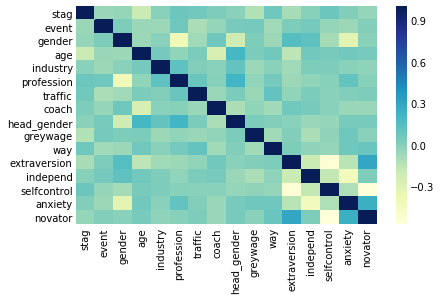

In [69]:
sns.heatmap(corrMatrix, 
           xticklabels=corrMatrix.columns.values,
           yticklabels=corrMatrix.columns.values, cmap="YlGnBu", annot=False)

The heatmap shows the following intermediate information:
- Positive correlation between
    - extraversion and novator (what is expected, though as extraverts are more likely to bring innovations that intraverts),
    - anxiety and novator (interesting, more anxious people are more innovative and vice versa)
- Negative correlation between 
    - selfcontrol and extraversion (intraverts are more of self-control)
    - independency and anxiety (less independent people are more anxious)
    - selfcontrol and novator (employees less controlling themselves are less likely to bring innovations)
    - age and tenure - more senior emplyees are less likely to quit (see histogram below)

However, no correlations exists on answer on our question -  on termination ("event") with other features

Building a histogram in a smoothed KDE form

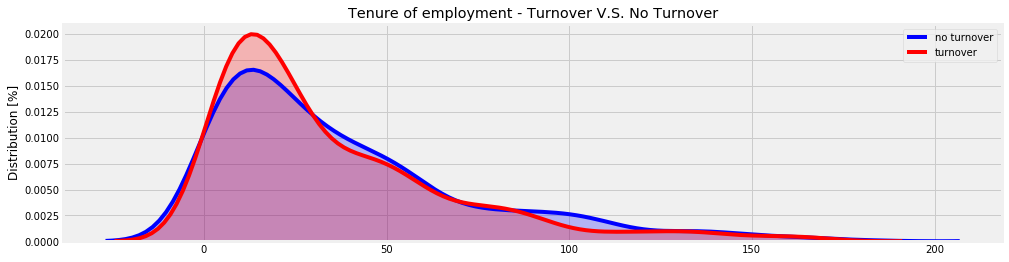

In [70]:
#Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['event'] == 0),'stag'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['event'] == 1),'stag'] , color='r',shade=True, label='turnover')
plt.title('Tenure of employment - Turnover V.S. No Turnover')
plt.ylabel('Distribution [%]')

Age vs turnover

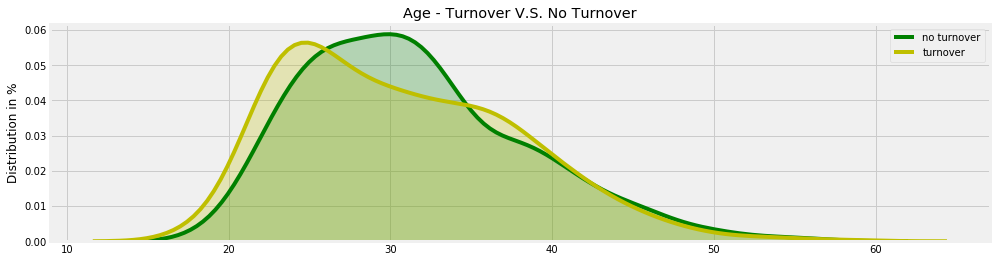

In [71]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['event'] == 0),'age'] , color='g',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['event'] == 1),'age'] , color='y',shade=True, label='turnover')
plt.title('Age - Turnover V.S. No Turnover')
plt.ylabel('Distribution in %')

From here it's seen that younger people are tend to quite more than more senior.

However, not that significant as seen from mean and median comparison:

In [72]:
df.groupby('event').age.mean()
df.groupby('event').age.median()

event
0    30.700166
1    30.000000
Name: age, dtype: float64

## 3. Testing & comparing prediction models.

In [73]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [74]:
# Create base rate model
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [75]:
# Create train and test splits
target_name = 'event'
X = df.drop(target_name, axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y=df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, stratify=y)

** 0. Base rate **

In [76]:
# Check accuracy of base rate model
y_base_rate = base_rate_model(X_test)
from sklearn.metrics import accuracy_score
print ("Base rate accuracy is %2.2f" % accuracy_score(y_test, y_base_rate))

Base rate accuracy is 0.50


**1. Logistic Regression **

In [77]:
# Check accuracy of Logistic Model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1)

model.fit(X_train, y_train)
print ("Logistic accuracy is %2.2f" % accuracy_score(y_test, model.predict(X_test)))

Logistic accuracy is 0.57


**1.1. Logistic Regression improved with K-Fold Validation **

In [78]:
# Using 10 fold Cross-Validation to train our Logistic Regression Model
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(class_weight = "balanced")
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.580 (0.073)


Not much better...

** 2. Random Forest<br>3. Decision Tree<br>4. AdaBoost**

In [79]:
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier


print ("---Base Model---")
base_roc_auc = roc_auc_score(y_test, base_rate_model(X_test))
print ("Base Rate AUC = %2.2f" % base_roc_auc)
print(classification_report(y_test, base_rate_model(X_test)))

# NOTE: By adding in "class_weight = balanced", the Logistic Auc increased by about 10%! This adjusts the threshold value
logis = LogisticRegression(class_weight = "balanced")
logis.fit(X_train, y_train)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(y_test, logis.predict(X_test))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, logis.predict(X_test)))

# Decision Tree Model
dtree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
dtree = dtree.fit(X_train,y_train)
print ("\n\n ---Decision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))

# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced"
    #min_weight_fraction_leaf=0.02 
    )
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))


# Ada Boost
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
ada.fit(X_train,y_train)
print ("\n\n ---AdaBoost Model---")
ada_roc_auc = roc_auc_score(y_test, ada.predict(X_test))
print ("AdaBoost AUC = %2.2f" % ada_roc_auc)
print(classification_report(y_test, ada.predict(X_test)))

---Base Model---
Base Rate AUC = 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       112
           1       0.00      0.00      0.00       114

   micro avg       0.50      0.50      0.50       226
   macro avg       0.25      0.50      0.33       226
weighted avg       0.25      0.50      0.33       226



 ---Logistic Model---
Logistic AUC = 0.57
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       112
           1       0.57      0.55      0.56       114

   micro avg       0.57      0.57      0.57       226
   macro avg       0.57      0.57      0.57       226
weighted avg       0.57      0.57      0.57       226



 ---Decision Tree Model---
Decision Tree AUC = 0.57
              precision    recall  f1-score   support

           0       0.56      0.61      0.58       112
           1       0.58      0.53      0.55       114

   micro avg       0.57      0.57      0.57   

**Although prediction quality is quite low, however building decision trees gives us a great opporutinity to range feature importance, so what features impact the most?**

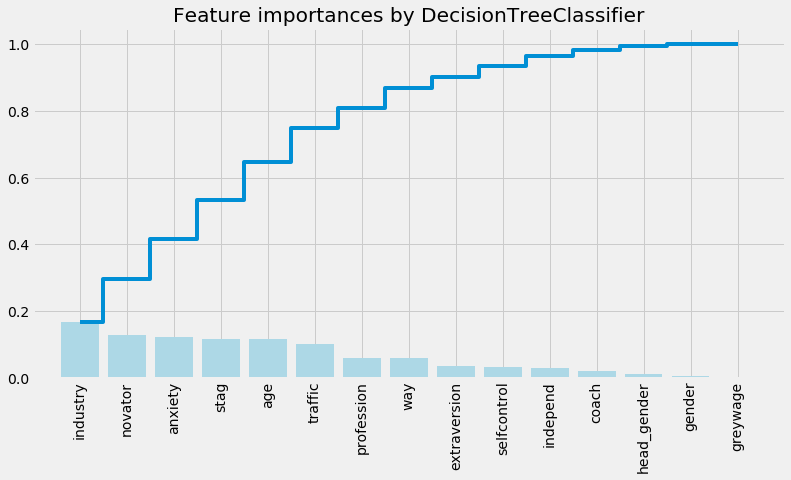

In [80]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df.drop(['event'],axis=1).columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [81]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(dtree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Employee Turnover") 

'Employee Turnover.pdf'

In [82]:
dot_data_to_display = tree.export_graphviz(dtree, out_file=None, 
                         feature_names=feat_names,  
                         class_names='turnover',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph_to_display = graphviz.Source(dot_data_to_display)
# Uncomment to display Decision Tree PDF
# graph_to_display

**5. CatBoost classifier**

In [83]:
from catboost import CatBoostClassifier, Pool

In [84]:
model_catboost = CatBoostClassifier(iterations=500,
                                   depth=4,
                                   learning_rate=1,
                                   loss_function='Logloss',
                                   verbose=True)
model_catboost.fit(X_train,y_train)

0:	learn: 0.6669637	total: 1.54ms	remaining: 770ms
1:	learn: 0.6440759	total: 2.5ms	remaining: 622ms
2:	learn: 0.6255832	total: 3.54ms	remaining: 587ms
3:	learn: 0.5986545	total: 4.88ms	remaining: 605ms
4:	learn: 0.5848749	total: 6ms	remaining: 594ms
5:	learn: 0.5648227	total: 6.85ms	remaining: 564ms
6:	learn: 0.5490802	total: 7.87ms	remaining: 554ms
7:	learn: 0.5213615	total: 9.52ms	remaining: 585ms
8:	learn: 0.5062318	total: 11.3ms	remaining: 615ms
9:	learn: 0.4925083	total: 12.7ms	remaining: 621ms
10:	learn: 0.4705723	total: 14ms	remaining: 621ms
11:	learn: 0.4572254	total: 15.1ms	remaining: 616ms
12:	learn: 0.4479478	total: 16.3ms	remaining: 611ms
13:	learn: 0.4315530	total: 17.9ms	remaining: 623ms
14:	learn: 0.4139168	total: 19.8ms	remaining: 639ms
15:	learn: 0.4072545	total: 21.2ms	remaining: 641ms
16:	learn: 0.3940003	total: 22.4ms	remaining: 638ms
17:	learn: 0.3835444	total: 23.6ms	remaining: 632ms
18:	learn: 0.3689727	total: 25ms	remaining: 633ms
19:	learn: 0.3566974	total: 25

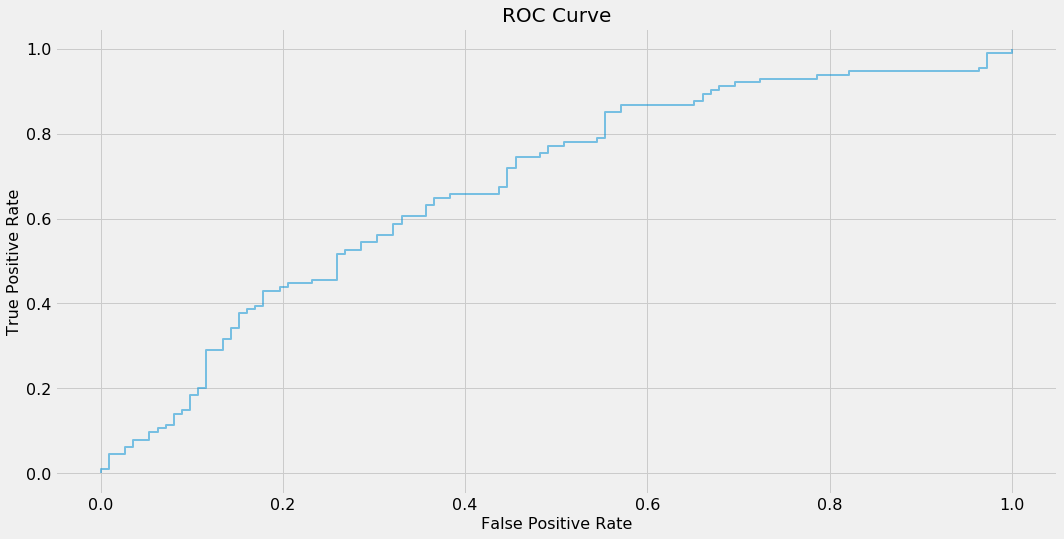

In [85]:
from catboost.utils import get_roc_curve
catboost_pool = Pool(X_test, y_test)
fpr, tpr, thresholds = get_roc_curve(model_catboost, catboost_pool, plot=True)

Catboost shows itself as one of the best along with Decision Trees.<br>
**6. Deep Neural Network with TensorFlow **

In [86]:
import tensorflow as tf
from tensorflow.estimator import DNNRegressor

In [87]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),  
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['AUC'])
  return model

In [88]:
model = get_compiled_model()

In [89]:
training_df = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)

In [90]:
model.fit(training_df, epochs=30)

Train for 903 steps
Epoch 1/30
903/903 [==============================] - 2s 2ms/step - loss: 0.6872 - AUC: 0.5647   

In [91]:
tf_fpr, tf_tpr, tf_thresholds = roc_curve(y_test, model.predict_proba(X_test))
print ("\n\n ---TF Model---")
tf_roc_auc = roc_auc_score(y_test,  tf.round(model.predict(X_test)))
print ("TF AUC = %2.2f" % tf_roc_auc)



 ---TF Model---
TF AUC = 0.58


**The result of DNN application is not better then much simplier methods!
Increasing/decreasing number of neurons and layers and increasing number of epochs don't improve the accuracy - it's about 60 percent.**

Let's try the most of it, and add K-Fold cross-validation to DNN<br>
**6.1. DNN with K-Fold CV**

In [92]:
#Folding Train dataset keeping Test reserved to check overfitting
from sklearn.model_selection import KFold
n_splits=10
for train_index,test_index in KFold(n_splits).split(X_train,y_train):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold=  y[train_index], y[test_index]
    model.fit(tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(1), epochs=30)
    print('Model evaluation ',model.evaluate(X_test_fold,y_test_fold))

Train for 812 steps
Epoch 1/30
812/812 [==============================] - 1s 1ms/step - loss: 0.4432 - AUC: 0.8788

In [93]:
tf_fpr, tf_tpr, tf_thresholds = roc_curve(y_test, model.predict_proba(X_test))
print ("\n\n ---TF Model---")
tf_roc_auc = roc_auc_score(y_test,  tf.round(model.predict(X_test)))
print ("TF AUC = %2.2f" % tf_roc_auc)



 ---TF Model---
TF AUC = 0.86


** Thus, the Receiver Operating Characteristics of all the tested approaches are as follows** 

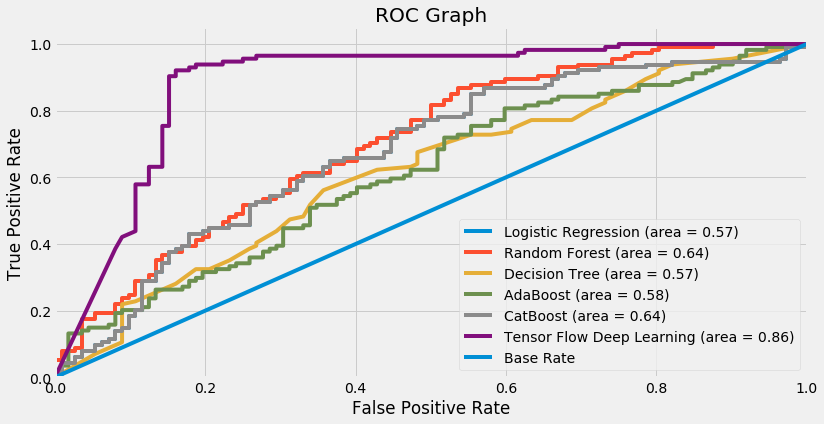

In [94]:

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)

# Plot AdaBoost ROC
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_roc_auc)

# Plot CatBoost ROC
plt.plot(cat_fpr, cat_tpr, label='CatBoost (area = %0.2f)' % cat_roc_auc)

# Plot TensorFlow ROC
plt.plot(tf_fpr, tf_tpr, label='Tensor Flow Deep Learning (area = %0.2f)' % tf_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()